In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision import transforms
from tqdm import tqdm
from tensorboardX import SummaryWriter
from net import *
from utils import *
from loss import *

### Data Preparation

In [2]:
root="D:/nyc_taxi"
mask_root='./masks'
log_dir='./logs/default'
LR=1e-4
MAX_ITER=50000
EVAL_ITER = 100
BATCH_SIZE=32
IMAGE_SIZE=64
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
torch.backends.cudnn.benchmark = True
device = torch.device('cuda')
writer = SummaryWriter(log_dir=log_dir)

In [3]:
size = (IMAGE_SIZE, IMAGE_SIZE)
img_tf = transforms.Compose([transforms.ToTensor()])
mask_tf = transforms.Compose([transforms.ToTensor()])
inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(MEAN, STD)],
   std= [1/s for s in STD]
)

In [4]:
dataset_train = taxi_data(root, mask_root, img_tf, mask_tf, 'train')
dataset_val = taxi_data(root, mask_root, img_tf, mask_tf, 'val')
dataset_test = taxi_data(root, mask_root, img_tf, mask_tf, 'test')
iterator_train = iter(data.DataLoader(
    dataset_train, batch_size=BATCH_SIZE,
    sampler=InfiniteSampler(len(dataset_train))))

In [5]:
model = PConvUNet(input_channels=1).to(device)
start_iter = 0
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
criterion = InpaintingLoss().to(device)
train_loss = []
val_loss = []

### Training

In [6]:
for i in tqdm(range(MAX_ITER)):
    
    ## training
    image, mask, gt = [x.to(device) for x in next(iterator_train)]
    
    output, _ = model(image, mask)
    
    loss = criterion(mask, output, gt)
    
    break
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())

  0%|                                                                                        | 0/50000 [00:01<?, ?it/s]


In [7]:
loss

tensor(0.0383, device='cuda:0', grad_fn=<AddBackward0>)

In [8]:
diff = torch.abs(output-gt)
l1 = torch.mean(diff)
l1

tensor(0.0155, device='cuda:0', grad_fn=<MeanBackward0>)

In [11]:
l2 = torch.mean((diff/(torch.min(output, gt)+1e-3))**1.2)
l2

tensor(51.6905, device='cuda:0', grad_fn=<MeanBackward0>)

In [19]:
x0 = 50
x1 = 20
2.7**(x0-x1)/(2.7**x0-2.7**x1)

2.35898248759284e-09

In [ ]:
for i in tqdm(range(MAX_ITER)):
    
    ## training
    image, mask, gt = [x.to(device) for x in next(iterator_train)]
    output, _ = model(image, mask)
    loss = criterion(mask, output, gt)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
    
    ## validation
    if (i + 1) % EVAL_ITER == 0 or (i + 1) == MAX_ITER:
        val_loss.append(evaluate(model, criterion, dataset_val, device, BATCH_SIZE))
        
writer.close()

In [14]:
torch.save(model.state_dict(), 'taxi-inpainting_dict')

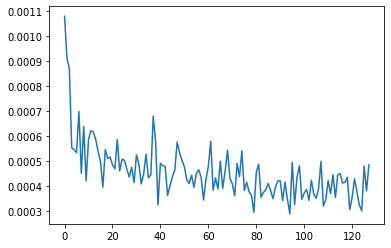

In [12]:
plt.plot(val_loss)
pass

### Test

In [8]:
model.load_state_dict(torch.load('taxi-inpainting_dict'))
model.to('cpu')
criterion.to('cpu')

InpaintingLoss(
  (l1): L1Loss()
)

In [ ]:
model.load_state_dict(torch.load('taxi-inpainting_dict'))
model.to('cpu')
criterion.to('cpu')
test_loss = 0
permutation = torch.randperm(len(dataset_test))     
for i in range(0, len(dataset_test), 2):
    indices = permutation[i:i+2]
    image, mask, gt = zip(*[dataset_test[i] for i in indices])
    image = torch.stack(image)
    mask = torch.stack(mask)
    gt = torch.stack(gt)
    output, _ = model(image, mask)
    output_comp = mask * image + (1 - mask) * output
    test_loss += criterion(mask, output_comp, gt)

In [11]:
print('Test Loss: {}'.format(round(test_loss.item()/len(dataset_test),4)))

Test Loss: 0.0075


### Test Visualization

In [15]:
num = 5
indices = np.random.randint(0, len(dataset_test),num)
image, mask, gt = zip(*[dataset_test[i] for i in indices])
image = torch.stack(image)
mask = torch.stack(mask)
gt = torch.stack(gt)
with torch.no_grad():
    output, _ = model(image, mask)
output_comp = mask * image + (1 - mask) * output

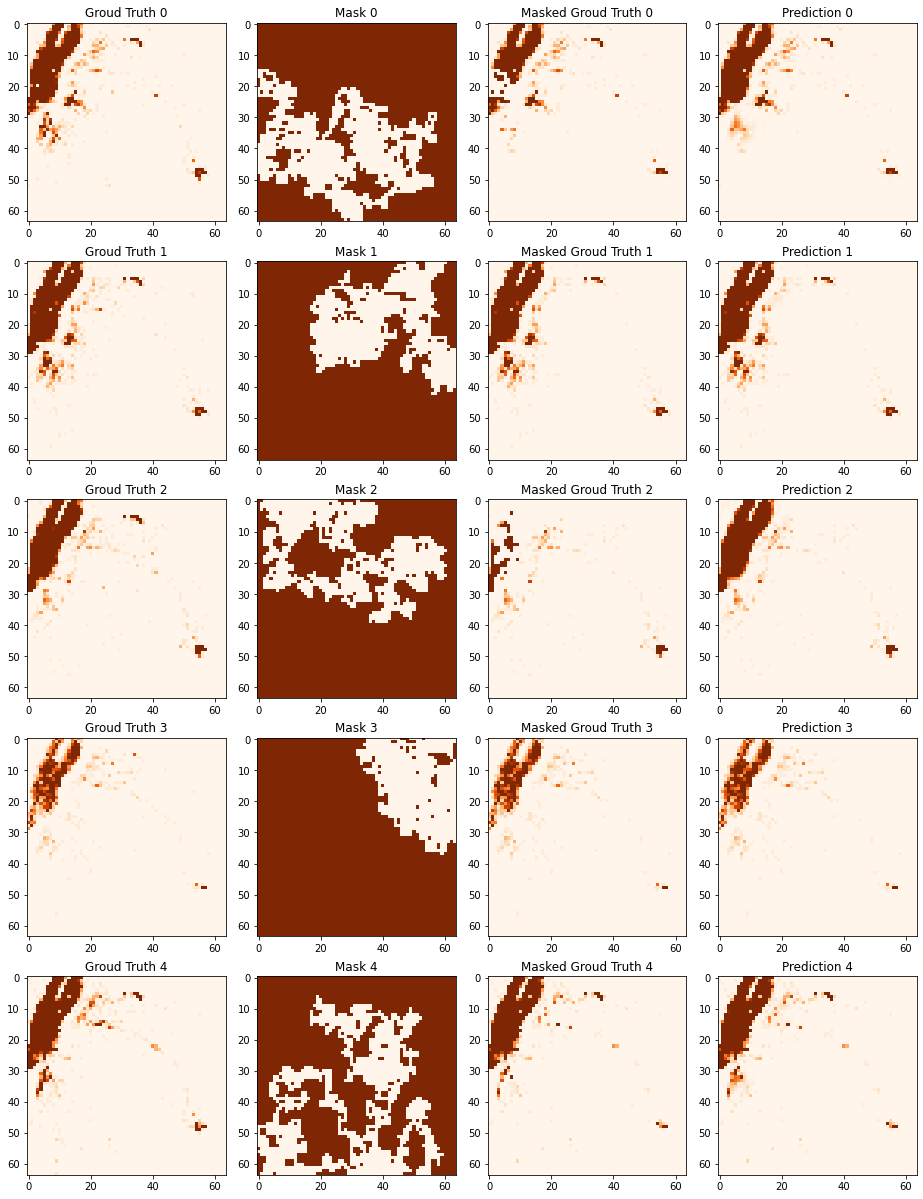

In [16]:
## visualizations
VMAX=0.055
fig, axs = plt.subplots(num, 4, figsize=(20,20))
for i in range(num):
    axs[i,0].imshow(gt[i][0],vmin=0, vmax=VMAX,cmap='Oranges')
    axs[i,0].set_title('Ground Truth '+ str(i))
    axs[i,1].imshow(mask[i][0],vmin=0, vmax=VMAX,cmap='Oranges')
    axs[i,1].set_title('Mask '+ str(i))
    axs[i,2].imshow(image[i][0],vmin=0, vmax=VMAX,cmap='Oranges')
    axs[i,2].set_title('Masked Ground Truth '+ str(i))
    axs[i,3].imshow(output_comp[i][0],vmin=0, vmax=VMAX,cmap='Oranges')
    axs[i,3].set_title('Prediction '+ str(i))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=-0.5, 
                    hspace=0.2)
plt.savefig('taxi-inpainting.png', dpi=600, bbox_inches='tight')